## Introduction

This notebook is dedicated to the development of a classification model for predicting the risk of having a stroke. In this notebook:
- I will try different boosting models and compare their performance.  
- Build the pipeline with preprocessing and estimation steps.  
- Use GridSearchCV to find the best parameters for the model.  
- Export the final pipeline for the deployment stage.

## Importing Necessary Libraries

In [20]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import functions as f
import pandas as pd
import numpy as np

from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    cross_val_score,
    train_test_split,
    GridSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from feature_engine.selection import DropCorrelatedFeatures, DropFeatures

import shap

shap.initjs()
import pickle

## Importing Train and Test sets from EDA Notebook

In [2]:
train_set = pd.read_csv("data/train_set.csv")
test_set = pd.read_csv("data/test_set.csv")

In [3]:

X_train = train_set.drop("stroke", axis=1)
y_train = train_set["stroke"]

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=True, random_state=33)

## Building the Pipeline

In [5]:
categorical_features = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "residence_type", "smoking_status"]
continuous_features = ["avg_glucose_level", "bmi"]
discrete_features = ["age"]

categorical_pipe = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
        ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="infrequent_if_exist")),
    ]
)
continuous_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy='mean', missing_values=np.nan)),
    ]
)
discrete_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy='median', missing_values=np.nan)),
    ]
)
preprocess_pipeline = ColumnTransformer(
    transformers=[
        ('categorical', categorical_pipe, categorical_features),
        ('continuous', continuous_pipe, continuous_features),
        ('discrete', discrete_pipe, discrete_features),
    ]
)
preprocess_pipeline.set_output(transform="pandas")

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                sparse_output=False))]),
                                 ['gender', 'hypertension', 'heart_disease',
                                  'ever_married', 'work_type', 'residence_type',
                                  'smoking_status']),
                                ('continuous',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['avg_glucose_level', 'bmi']),
                                ('discrete',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['age'])])

## Training the Boosting Models

XGBClassifier
Cross-validation Accuracy: 0.929 (0.007)
------------------------------------------------------------------
MODEL EVALUATION ON TRAINING SET


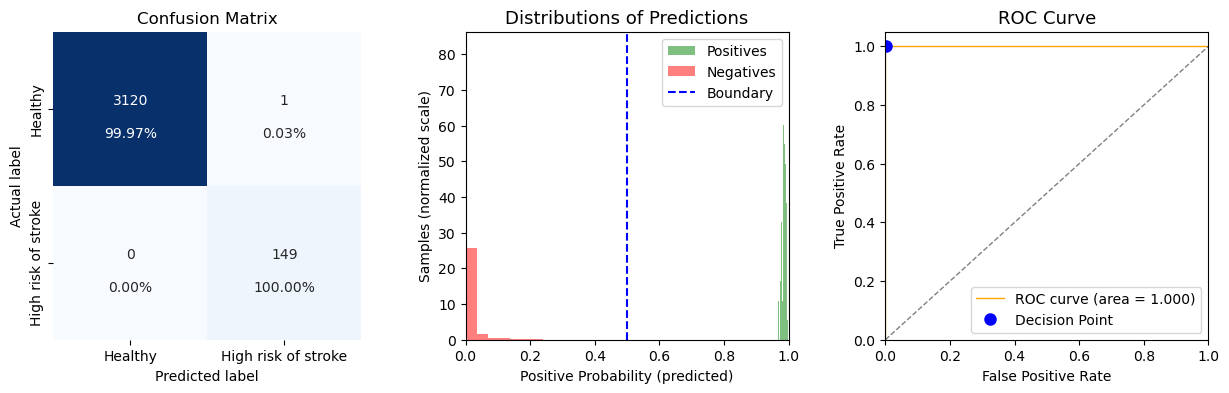

Precision: 0.993 | Recall: 1.0 | F1 Score: 0.997 | AUC: 1.0
------------------------------------------------------------------
MODEL EVALUATION ON VALIDATION SET


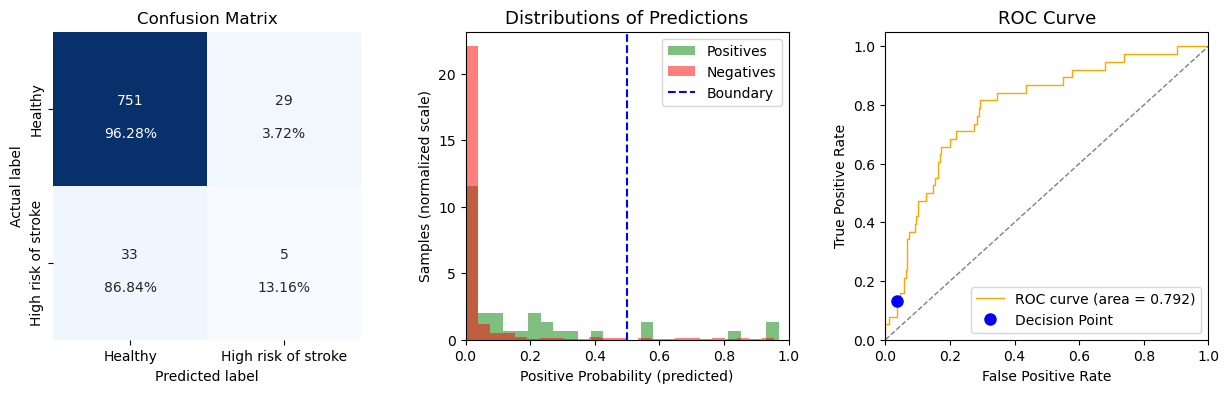

Precision: 0.147 | Recall: 0.132 | F1 Score: 0.139 | AUC: 0.792
------------------------------------------------------------------
LGBMClassifier
Cross-validation Accuracy: 0.923 (0.009)
------------------------------------------------------------------
MODEL EVALUATION ON TRAINING SET


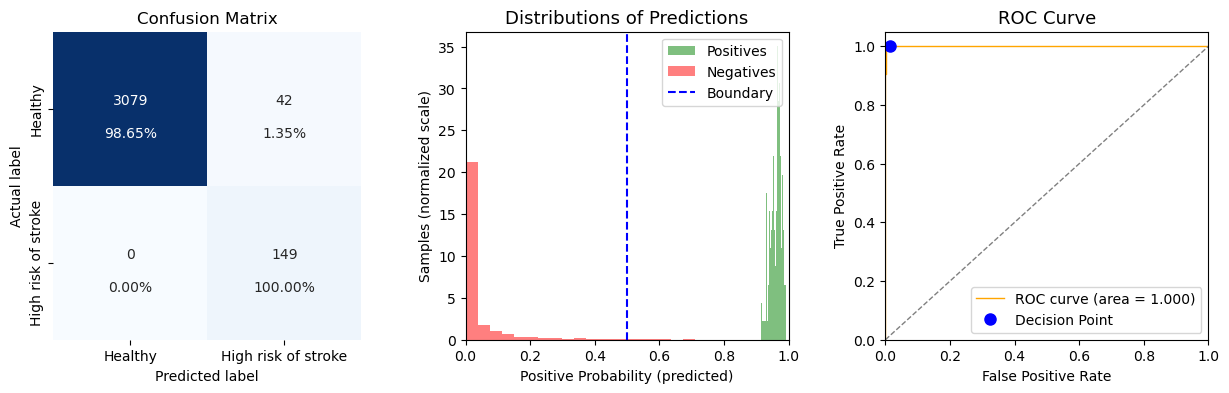

Precision: 0.78 | Recall: 1.0 | F1 Score: 0.876 | AUC: 1.0
------------------------------------------------------------------
MODEL EVALUATION ON VALIDATION SET


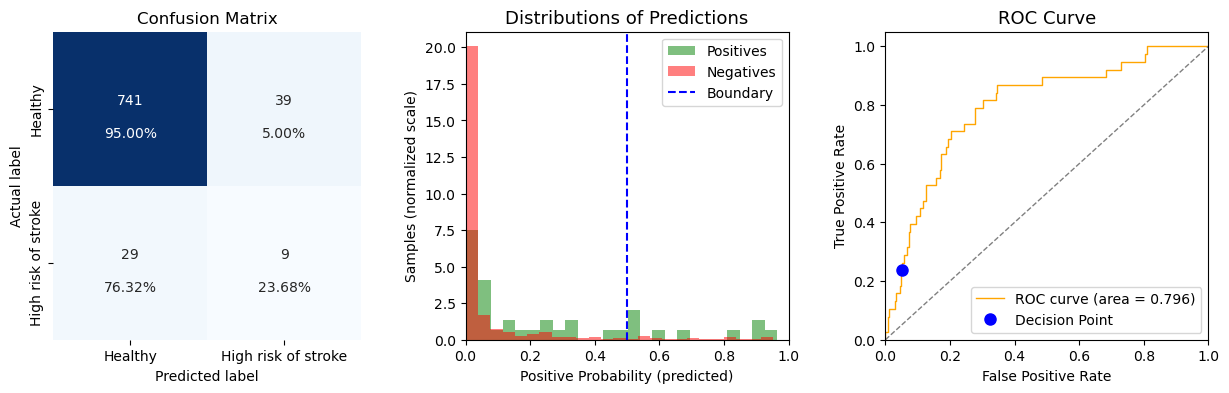

Precision: 0.188 | Recall: 0.237 | F1 Score: 0.209 | AUC: 0.796
------------------------------------------------------------------
CatBoostClassifier
Cross-validation Accuracy: 0.904 (0.013)
------------------------------------------------------------------
MODEL EVALUATION ON TRAINING SET


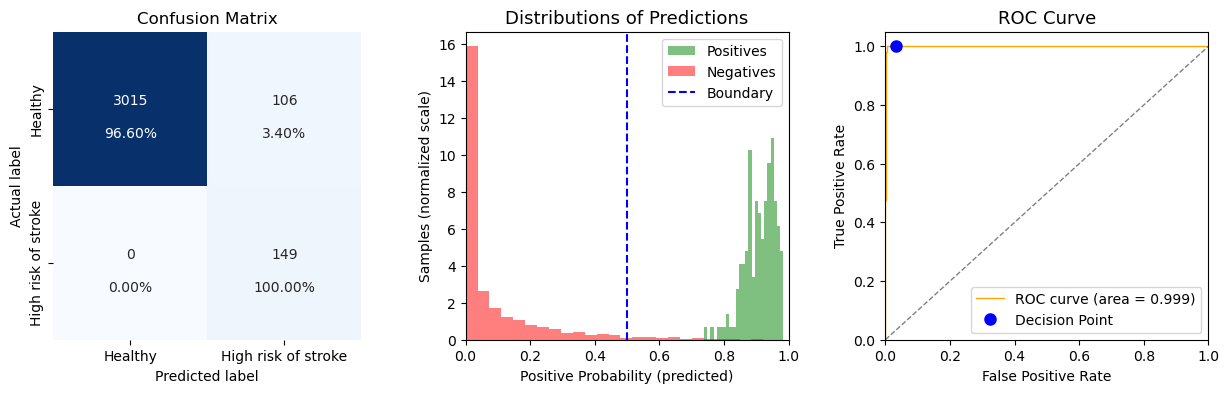

Precision: 0.584 | Recall: 1.0 | F1 Score: 0.738 | AUC: 0.999
------------------------------------------------------------------
MODEL EVALUATION ON VALIDATION SET


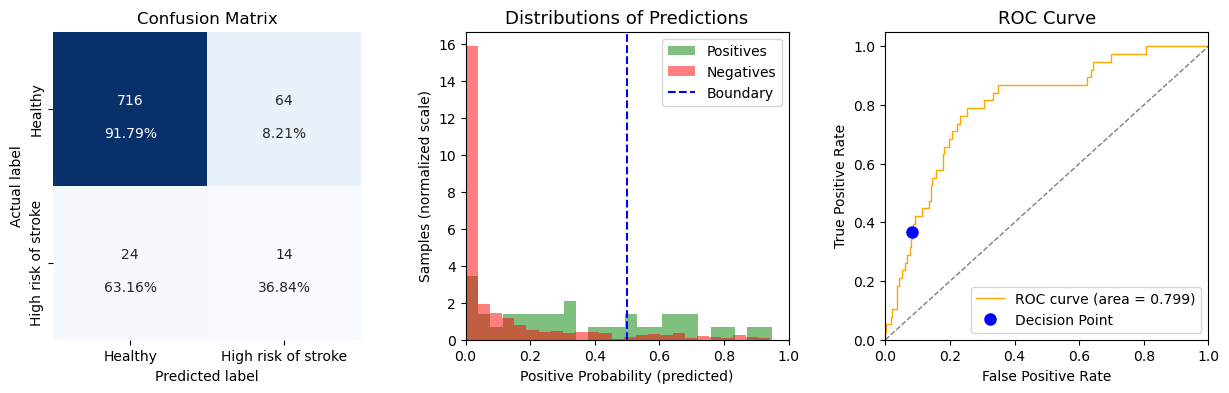

Precision: 0.179 | Recall: 0.368 | F1 Score: 0.241 | AUC: 0.799
------------------------------------------------------------------


In [6]:
# calculate the ratio of the class labels
weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

classifiers = [
    XGBClassifier(random_state=1, n_jobs=-1, scale_pos_weight=weight),
    LGBMClassifier(random_state=1, n_jobs=-1, scale_pos_weight=weight),
    CatBoostClassifier(random_state=1, verbose=False, scale_pos_weight=weight),
]
for classifier in classifiers:
    pipeline = Pipeline(
        steps=[
            ("preprocess", preprocess_pipeline),
            ("drop_correlated", DropCorrelatedFeatures(threshold=0.7)),
            ("clf", classifier),
        ]
    )
    print(classifier.__class__.__name__)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(
        pipeline, X_train, y_train, scoring="accuracy", cv=cv)
    # report performance
    print("Cross-validation Accuracy: %.3f (%.3f)" % (np.mean(n_scores), np.std(n_scores)))
    print("------------------------------------------------------------------")
    pipeline.fit(X_train, y_train)
    print("MODEL EVALUATION ON TRAINING SET")
    y_pred = pipeline.predict_proba(X_train)
    f.binary_performances(y_train, y_pred, categories=["Healthy", "High risk of stroke"])
    print("------------------------------------------------------------------")
    print("MODEL EVALUATION ON VALIDATION SET")
    y_pred = pipeline.predict_proba(X_valid)
    f.binary_performances(y_valid, y_pred, categories=["Healthy", "High risk of stroke"])
    print("------------------------------------------------------------------")

## Fine Tuning the Selected Model

In [7]:
pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_pipeline),
    ]
)

In [8]:
X_prepared = pipeline.fit_transform(X_train)

In [9]:
model = LGBMClassifier(random_state=1, n_jobs=-1, scale_pos_weight=weight).fit(X_prepared, y_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


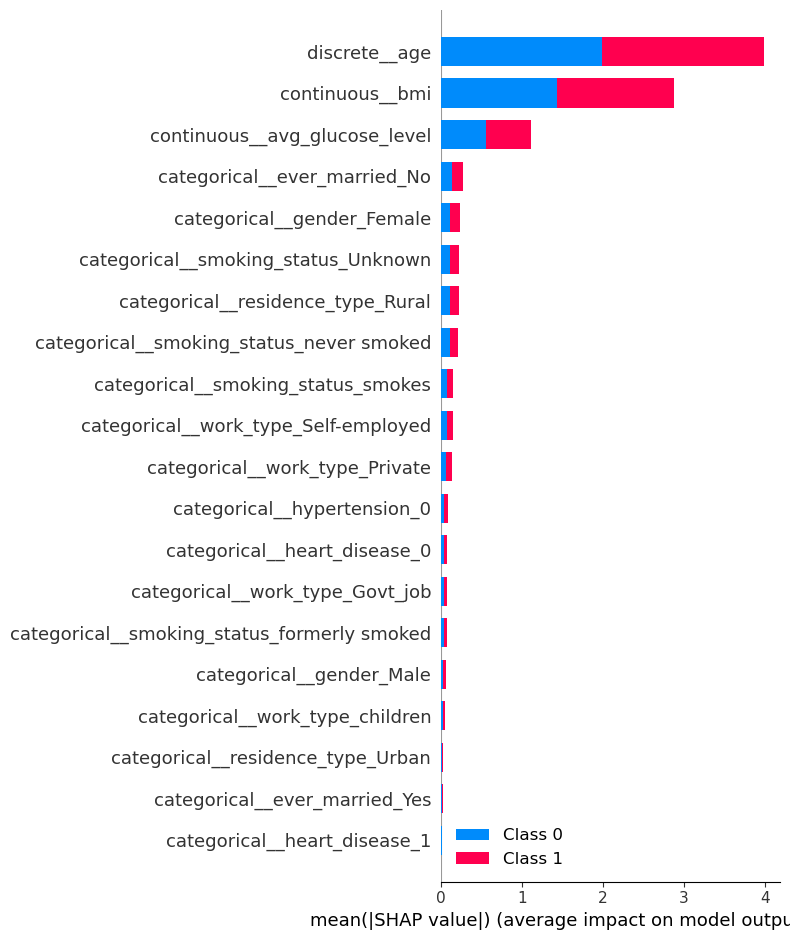

In [10]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_prepared)
shap.summary_plot(shap_values, X_prepared)

In [11]:
feat_list = [
    "categorical__gender_Female",
    "categorical__gender_Male",
    "categorical__hypertension_0",
    "categorical__hypertension_1",
    "categorical__heart_disease_0",
    "categorical__heart_disease_1",
    "categorical__ever_married_No",
    "categorical__ever_married_Yes",
    "categorical__work_type_Govt_job",
    "categorical__work_type_Never_worked",
    "categorical__work_type_Private",
    "categorical__work_type_Self-employed",
    "categorical__work_type_children",
    "categorical__residence_type_Rural",
    "categorical__residence_type_Urban",
    "categorical__smoking_status_Unknown",
    "categorical__smoking_status_formerly smoked",
    "categorical__smoking_status_never smoked",
    "categorical__smoking_status_smokes",
]
pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_pipeline),
        ("drop_features", DropFeatures(feat_list)),
        ("clf", LGBMClassifier(random_state=1, n_jobs=-1, scale_pos_weight=weight)),
    ]
)

Cross-validation Accuracy: 0.909 (0.014)
------------------------------------------------------------------
MODEL EVALUATION ON TRAINING SET


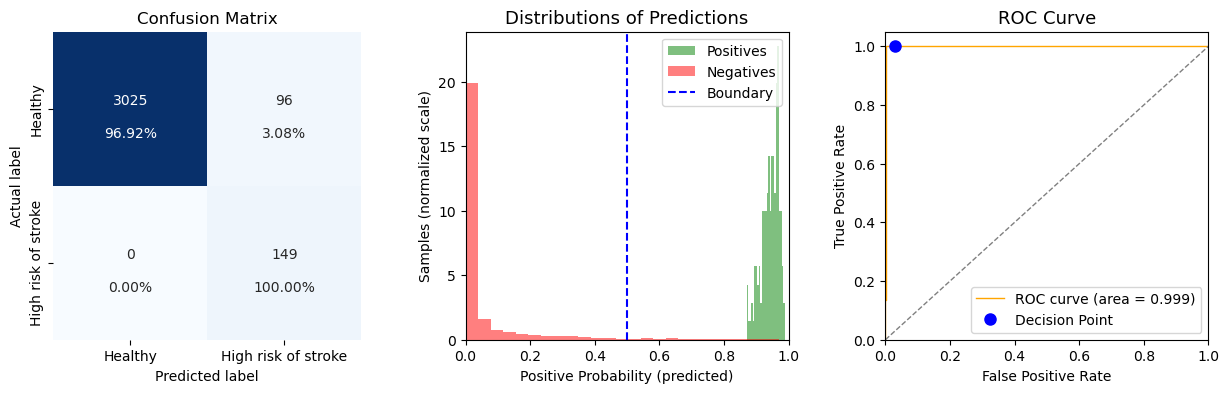

Precision: 0.608 | Recall: 1.0 | F1 Score: 0.756 | AUC: 0.999
------------------------------------------------------------------
MODEL EVALUATION ON VALIDATION SET


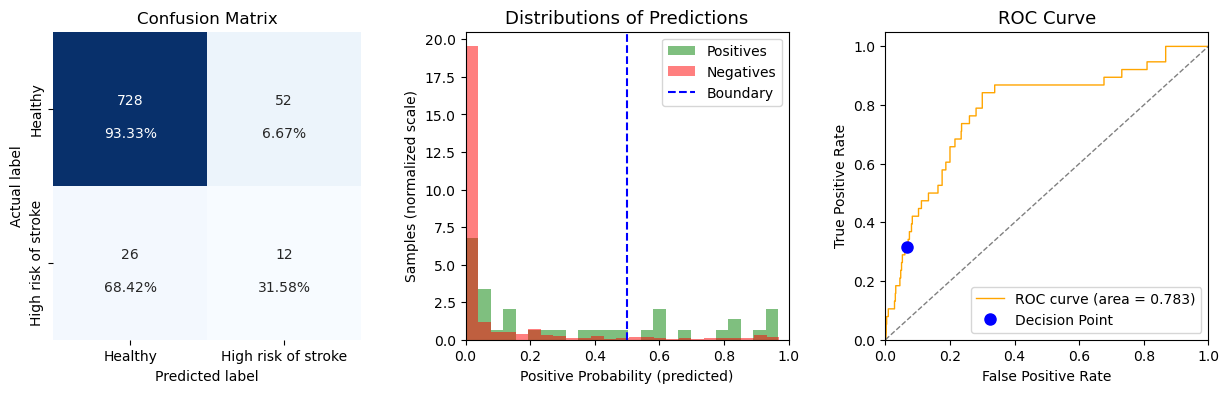

Precision: 0.188 | Recall: 0.316 | F1 Score: 0.235 | AUC: 0.783
------------------------------------------------------------------


In [12]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(
    pipeline, X_train, y_train, scoring="accuracy", cv=cv)
# report performance
print("Cross-validation Accuracy: %.3f (%.3f)" % (np.mean(n_scores), np.std(n_scores)))
print("------------------------------------------------------------------")
pipeline.fit(X_train, y_train)
print("MODEL EVALUATION ON TRAINING SET")
y_pred = pipeline.predict_proba(X_train)
f.binary_performances(y_train, y_pred, categories=["Healthy", "High risk of stroke"])
print("------------------------------------------------------------------")
print("MODEL EVALUATION ON VALIDATION SET")
y_pred = pipeline.predict_proba(X_valid)
f.binary_performances(y_valid, y_pred, categories=["Healthy", "High risk of stroke"])
print("------------------------------------------------------------------")

## Grid Search for Hyperparameter Tuning

In [13]:
param_grid = {
    "clf__boosting": ["gbdt", "dart"],
    "clf__learning_rate": [0.1, 0.01, 0.05],
    "clf__num_iterations": [100, 140, 180, 220],
    "clf__max_bin": [50, 55, 60],
    "clf__num_leaves": [15, 25, 30],
    "clf__min_gain_to_split": [0, 0.5, 1],
    "clf__max_depth": [2, 3, 4, 5, 6],
    "clf__extra_trees": [True, False],
}

In [14]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=2,
    verbose=True
)
# # IT TAKES 2 HOURS TO RUN
# grid_search.fit(X_train, y_train)

## Final Pipeline

In [15]:
pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_pipeline),
        ("drop_features", DropFeatures(feat_list)),
        (
            "clf",
            LGBMClassifier(
                boosting_type="dart",
                extra_trees=True,
                learning_rate=0.05,
                max_bin=50,
                max_depth=5,
                num_leaves=25,
                scale_pos_weight=weight,
                n_jobs=-1,
                random_state=1,
            ),
        ),
    ]
)

MODEL EVALUATION ON TRAINING SET


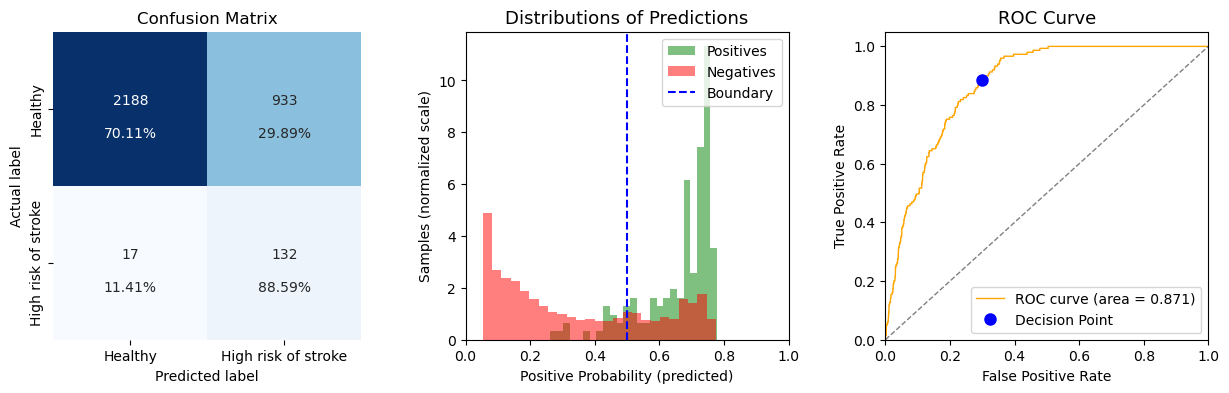

Precision: 0.124 | Recall: 0.886 | F1 Score: 0.217 | AUC: 0.871
------------------------------------------------------------------
MODEL EVALUATION ON VALIDATION SET


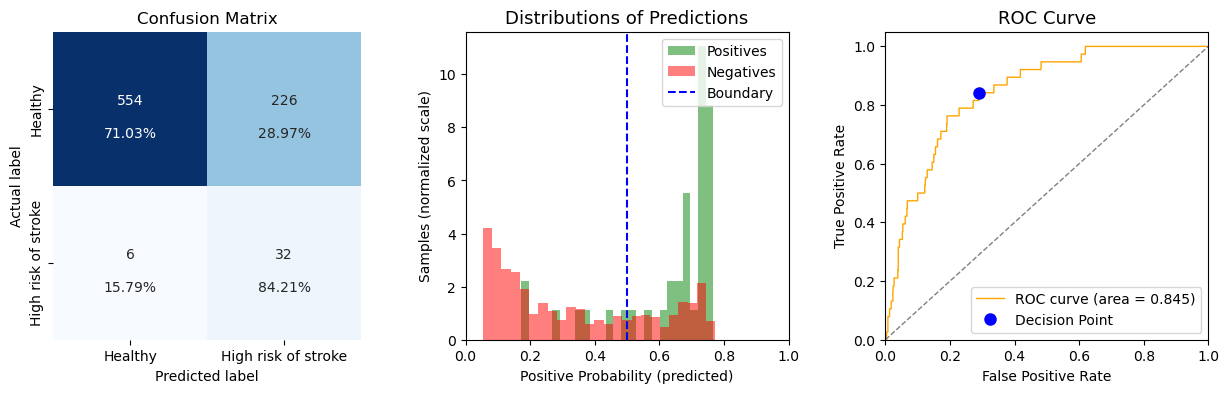

Precision: 0.124 | Recall: 0.842 | F1 Score: 0.216 | AUC: 0.845
------------------------------------------------------------------


In [16]:
pipeline.fit(X_train, y_train)
print("MODEL EVALUATION ON TRAINING SET")
y_pred = pipeline.predict_proba(X_train)
f.binary_performances(y_train, y_pred, categories=["Healthy", "High risk of stroke"])
print("------------------------------------------------------------------")
print("MODEL EVALUATION ON VALIDATION SET")
y_pred = pipeline.predict_proba(X_valid)
f.binary_performances(y_valid, y_pred, categories=["Healthy", "High risk of stroke"])
print("------------------------------------------------------------------")

## Evaluating Final Model on Test Set

In [17]:
X_test = test_set.drop("stroke", axis=1)
y_test = test_set["stroke"]

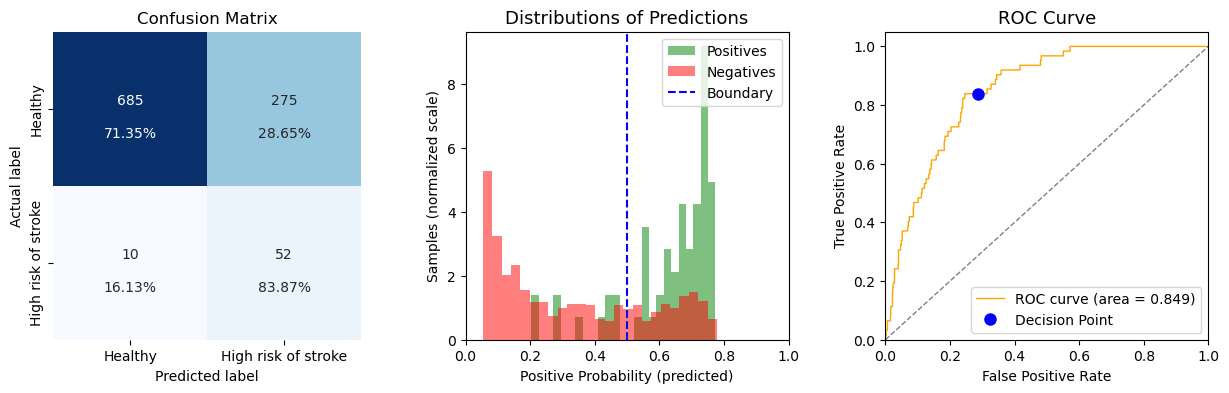

Precision: 0.159 | Recall: 0.839 | F1 Score: 0.267 | AUC: 0.849


{'Precision': 0.15902140672782875,
 'Recall': 0.8387096774193549,
 'F1 Score': 0.2673521850899743,
 'AUC': 0.8494371639784946}

In [18]:
y_pred = pipeline.predict_proba(X_test)
f.binary_performances(y_test, y_pred, categories=["Healthy", "High risk of stroke"])

## Saving the pipeline

In [19]:
# with open("lgbm_pipeline-0.1.0.pkl", "wb") as f:
#     pickle.dump(pipeline, f)

## Conclusion

In this project I tried three different boosting models: XGBClassifier, CatBoostClassifier and LGBMClassifier. The model which performed the best was the LGBMClassifier which I picked as a final model for deployment. The data was extremely imbalanced so it was hard to accurately predict the positive class. But in the end result the model performed with 0.84 recall score which is not that bad in this case. Because the point of this model is to predict the patients risk of having a stroke based on some easily obtainable features. So it's better to have some false negative cases then the false positive ones and do further testing on the patients who are predicted to be at risk then to have a lot of patients which were not further tested because they were predicted to be false positives.

## What could be improved

- Model parameter tuning. Try different parameter combinations.
- Feature engineering. Create some new features.